#  Vibe Matcher — AI-Based Fashion Recommender  
**By Taniya Sumbul**

### Why AI at Nexora?
AI can translate human emotions and moods into machine-understandable patterns.  
“Vibe Matcher” shows how semantic embeddings can connect a user's *vibe* (like “boho” or “urban chic”) to real product recommendations.  
At Nexora, AI like this bridges creativity and data—making discovery more human-centered.
# New Section

In [3]:
# VIBE MATCHER — Local Version (No API Key Needed)


!pip install sentence-transformers pandas scikit-learn matplotlib tqdm --quiet

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


# 1️ Load embedding model (FREE)

model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight & fast


# 2️ Sample product data

products = [
    {"id": 1, "name": "Boho Dress", "desc": "Flowy maxi dress, earthy tones, embroidered details — festival and beach vibes.", "tags": ["boho", "festival", "flowy"]},
    {"id": 2, "name": "Urban Bomber Jacket", "desc": "Cropped bomber with reflective trim, edgy streetwear for late-night city runs.", "tags": ["urban", "edgy", "street"]},
    {"id": 3, "name": "Cozy Knit Sweater", "desc": "Chunky knit, oversized fit, warm and snuggly for cozy nights in.", "tags": ["cozy", "loungewear", "warm"]},
    {"id": 4, "name": "Minimalist Slip Dress", "desc": "Sleek slip dress with clean lines for modern minimalists and date nights.", "tags": ["minimal", "elegant", "date-night"]},
    {"id": 5, "name": "Sporty Windbreaker", "desc": "Lightweight windbreaker, waterproof, energetic and active outdoor vibes.", "tags": ["sporty", "active", "outdoors"]},
    {"id": 6, "name": "Vintage Denim Jacket", "desc": "Worn-in denim with patchwork and retro wash for nostalgic, casual looks.", "tags": ["vintage", "casual", "retro"]},
    {"id": 7, "name": "Chic Pleated Skirt", "desc": "High-waist pleated skirt, versatile for office-to-evening transitions.", "tags": ["chic", "office", "versatile"]},
    {"id": 8, "name": "Electric Sneaker", "desc": "Bold color-pop sneakers with cushioned sole for energetic urban street style.", "tags": ["energetic", "urban", "sneakers"]},
]

df = pd.DataFrame(products)
df["text_for_embedding"] = df["name"] + ". " + df["desc"] + " Tags: " + df["tags"].apply(lambda t: " ".join(t))
display(df.head())


,id,name,desc,tags,text_for_embedding
0,1,Boho Dress,"Flowy maxi dress, earthy tones, embroidered de...","[boho, festival, flowy]","Boho Dress. Flowy maxi dress, earthy tones, em..."
1,2,Urban Bomber Jacket,"Cropped bomber with reflective trim, edgy stre...","[urban, edgy, street]",Urban Bomber Jacket. Cropped bomber with refle...
2,3,Cozy Knit Sweater,"Chunky knit, oversized fit, warm and snuggly f...","[cozy, loungewear, warm]","Cozy Knit Sweater. Chunky knit, oversized fit,..."
3,4,Minimalist Slip Dress,Sleek slip dress with clean lines for modern m...,"[minimal, elegant, date-night]",Minimalist Slip Dress. Sleek slip dress with c...
4,5,Sporty Windbreaker,"Lightweight windbreaker, waterproof, energetic...","[sporty, active, outdoors]","Sporty Windbreaker. Lightweight windbreaker, w..."


In [4]:
#  Compute product embeddings

print("Generating product embeddings...")
start = time.time()
df["embedding"] = list(model.encode(df["text_for_embedding"], show_progress_bar=True))
end = time.time()
print(f"Embeddings created in {end-start:.2f} seconds.")

emb_matrix = np.vstack(df["embedding"].values)

Generating product embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings created in 0.33 seconds.


In [5]:
# 4️ Define vibe matching function

def match_vibe(query, top_k=3, fallback_threshold=0.35):
    """Return top_k matching products based on vibe query"""
    start_time = time.time()
    q_emb = model.encode([query])
    sims = cosine_similarity(q_emb, emb_matrix)[0]
    top_idx = np.argsort(sims)[::-1][:top_k]
    results = []
    for idx in top_idx:
        results.append({
            "id": int(df.iloc[idx]["id"]),
            "name": df.iloc[idx]["name"],
            "desc": df.iloc[idx]["desc"],
            "score": float(sims[idx])
        })
    latency = time.time() - start_time
    best_score = sims[top_idx[0]]
    return results, best_score, latency

In [6]:
#  Test with sample vibe queries

queries = [
    "energetic urban chic",
    "warm cozy loungewear",
    "bohemian flowy festival dress"
]

metrics = []
for q in queries:
    print(f"\n Query: '{q}'")
    results, best_score, latency = match_vibe(q)
    for i, r in enumerate(results, 1):
        print(f"  Rank {i}: {r['name']} — (score: {r['score']:.3f})")
    is_good = best_score >= 0.7
    print(f"Best Score: {best_score:.3f} | Good Match? {is_good} | Latency: {latency:.3f}s")
    metrics.append({"query": q, "best_score": best_score, "is_good": is_good, "latency": latency})

metrics_df = pd.DataFrame(metrics)
display(metrics_df)


 Query: 'energetic urban chic'
  Rank 1: Electric Sneaker — (score: 0.435)
  Rank 2: Urban Bomber Jacket — (score: 0.385)
  Rank 3: Chic Pleated Skirt — (score: 0.306)
Best Score: 0.435 | Good Match? False | Latency: 0.022s

 Query: 'warm cozy loungewear'
  Rank 1: Cozy Knit Sweater — (score: 0.641)
  Rank 2: Vintage Denim Jacket — (score: 0.381)
  Rank 3: Minimalist Slip Dress — (score: 0.380)
Best Score: 0.641 | Good Match? False | Latency: 0.016s

 Query: 'bohemian flowy festival dress'
  Rank 1: Boho Dress — (score: 0.555)
  Rank 2: Minimalist Slip Dress — (score: 0.553)
  Rank 3: Vintage Denim Jacket — (score: 0.373)
Best Score: 0.555 | Good Match? False | Latency: 0.019s


,query,best_score,is_good,latency
0,energetic urban chic,0.435346,False,0.021921
1,warm cozy loungewear,0.641025,False,0.015858
2,bohemian flowy festival dress,0.554607,False,0.018971


In [7]:
# -------------------------
#  Handle low-confidence fallback
# -------------------------
def present_results(query, top_k=3, fallback_threshold=0.35):
    res, best_score, latency = match_vibe(query, top_k)
    if best_score < fallback_threshold:
        all_tags = sum(df["tags"].tolist(), [])
        common_tags = pd.Series(all_tags).value_counts().index[:3].tolist()
        print(f"\n Low confidence ({best_score:.3f}). Maybe you meant one of these vibes: {common_tags}")
    for i, r in enumerate(res, 1):
        print(f"  Rank {i}: {r['name']} — {r['desc']} (score={r['score']:.3f})")
    print(f"Latency: {latency:.3f}s\n")

present_results("formal corporate wear")


  Rank 1: Minimalist Slip Dress — Sleek slip dress with clean lines for modern minimalists and date nights. (score=0.418)
  Rank 2: Vintage Denim Jacket — Worn-in denim with patchwork and retro wash for nostalgic, casual looks. (score=0.412)
  Rank 3: Boho Dress — Flowy maxi dress, earthy tones, embroidered details — festival and beach vibes. (score=0.393)
Latency: 0.020s



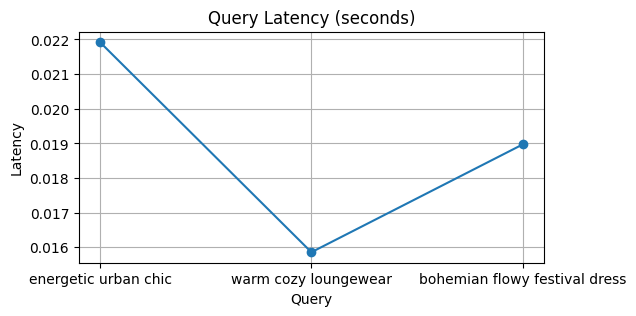


 0/3 queries had 'good' matches (score >= 0.7)


,query,best_score,is_good,latency
0,energetic urban chic,0.435346,False,0.021921
1,warm cozy loungewear,0.641025,False,0.015858
2,bohemian flowy festival dress,0.554607,False,0.018971


In [8]:
# -------------------------
#  Plot latency results
# -------------------------
plt.figure(figsize=(6,3))
plt.plot(metrics_df["query"], metrics_df["latency"], marker='o')
plt.title("Query Latency (seconds)")
plt.xlabel("Query")
plt.ylabel("Latency")
plt.grid(True)
plt.show()

# -------------------------
#  Evaluation summary
# -------------------------
num_good = metrics_df["is_good"].sum()
print(f"\n {num_good}/{len(metrics_df)} queries had 'good' matches (score >= 0.7)")
metrics_df